### Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import math
import numpy as np
import  wandb
import os
import time

from torchmetrics import Dice
import segmentation_models_pytorch as smp
from loss.loss import Criterion

## depend to the files of the project
import utils 
from utils import load, save, plot
from benchmark import dataset
from methods import unet, unetplusplus, deeplab
from utils import load, save, plot

### Loading the WandB

In [2]:
key_file = './wandb-key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sepehr-eslami2019 (face-estimation). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\USER/.netrc


### Arguments

In [3]:
seed = 3
wandb_enable = True

info = {'num_epoch' :10,
        'lr' : 0.5,
        'weight_decay' : 1e-05,
        'device' : 'cuda',
        'reset': True,
        'name_load' : 'deeplab-efficientnet(BCE&Tversky)',
        'model_load_path' : './saved_model/',
        'model_save_path' : './saved_model/'
        }


Initialize `wandb`

In [6]:
wandb_arg_name = 'deeplab-efficientnet' # name of this training process
wandb.init(
        project='Medical Image Segmentation(BCE&Tversky)',  # name of the project
        name=wandb_arg_name,
        config={
            'lr': info['lr'],
            'weight_decay': info['weight_decay'],
            'num_epoch': info['num_epoch']
        }
    )


### Main Loop

In [4]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

Deffine the `Dataloader`

In [5]:
train_batch_size = 16
valid_batch_size = 38

train_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='train', mini=False, memory=True)(batch_size=train_batch_size)
valid_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='valid', mini=False, memory=False)(batch_size=valid_batch_size)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


 Define the `Model` - `Optimizer` - `Loss Function` - `Metric`

In [7]:
load_path = info['model_load_path'] + info['name_load'] + ".pth"

###############
#    Model    #
###############

# model = unet.UNet(n_channels=3, n_classes=3, bilinear=False).to(info['device'])  ## my unet arhitesture
# model = unet.pre_train_unet(encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained unet with efficientnet encoder
# model = unetplusplus.UnetPlusPlus(encoder_name='resnet18').to(info['device'])  ## Pre-trained unet++ archoteture with efficientnet encoder 
model = deeplab.DeepLab(encoder_name='efficientnet-b1').to(info['device'])  ## Pre-trained DeepLabv3 archoteture with efficientnet encoder 


optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)# , nesterov=True
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

# loss_fn = smp.losses.DiceLoss(mode='multilabel')
loss_fn = Criterion()

metric = Dice().to(info['device'])

model, loss_fn, _ = load(model, loss_fn, optimizer, device=info['device'], reset = info['reset'], load_path = load_path)

save_path = info['model_save_path'] + info['name_load']+ ".pth"

In [49]:
optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=int(30000/32*10)+50, 
#                                                    eta_min=1e-6) 

**`Training`**

In [8]:
epochs = info['num_epoch']

for epoch in range(1, epochs+1):
    ## Train
    model, loss_train, metric_train = utils.train_one_epoch(model,
                                                            train_loader,
                                                            loss_fn,
                                                            optimizer,
                                                            metric,
                                                            epoch,
                                                            device=info['device'])
    
    ## Validation
    loss_valid, metric_valid = utils.evaluate(model,
                                              valid_loader,
                                              loss_fn,
                                              metric,
                                              device=info['device'])

        
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)


    print(f'Train      - Loss:{loss_train}  Metric:{metric_train}')
    print(f'Validation - Loss:{loss_valid}  Metric:{metric_valid}')
    print(f'LR = {lr_scheduler.get_last_lr()[0]}')
    print()

    if loss_valid < best_loss_valid:
        save(save_path, model, optimizer, loss_fn)
        best_loss_valid = loss_valid
        print('Model Saved ("o")')

    if wandb_enable:
        wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                   "metric_valid": metric_valid, "loss_valid": loss_valid})
        
    # lr_scheduler.step()

    epoch_counter += 1





Epoch 1:   0%|          | 0/752 [00:00<?, ?batch/s]

In [13]:
wandb.finish()

loss_train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_valid,█▅▅▄▃▂▃▂▂▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metric_train,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
metric_valid,▁▃▄▅▆▇▆▇▇▆▆▆▆▇▇███████████████
loss_train,0.05719
loss_valid,0.11776
metric_train,0.89815
metric_valid,0.7964


In [37]:
save(save_path, model, optimizer, loss_fn)

### Plot learning curves


Trained 30 epochs


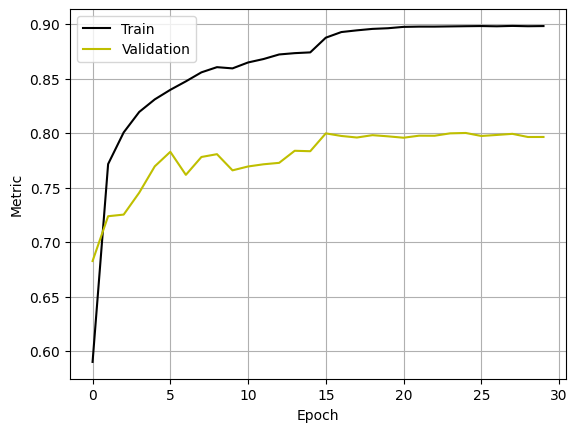


Trained 30 epochs


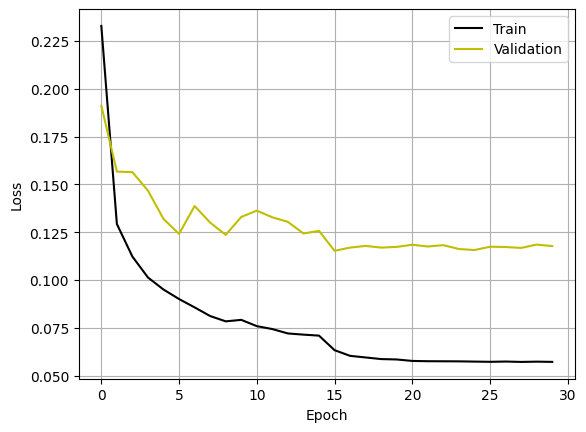

In [12]:
plot(metric_train_hist, metric_valid_hist, "Metric")
plot(loss_train_hist, loss_valid_hist, 'Loss')